In [ ]:
import os, pathlib
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Set seeds
np.random.seed(1)
tf.random.set_seed(1)

# Define parameters
batch_size = 32
height = 400
width = 400

init_train_ds = keras.preprocessing.image_dataset_from_directory(
    "drive/My Drive/CLASSIFY_BALANCED_VAL/TRAIN",
    batch_size=batch_size,
    image_size=(1000, 1000),
    label_mode="int",
    crop_to_aspect_ratio=True,
)
init_val_ds = keras.preprocessing.image_dataset_from_directory(
    "drive/My Drive/CLASSIFY_BALANCED_VAL/VAL",
    batch_size=batch_size,
    image_size=(1000, 1000),
    label_mode="int",
    crop_to_aspect_ratio=True,
)

# Random crop
random_crop = keras.Sequential([keras.layers.RandomCrop(height, width, seed=1)])
train_ds = init_train_ds.map(lambda x, y: (random_crop(x), y))
# Center crop
center_crop = keras.Sequential([keras.layers.CenterCrop(height, width)])
val_ds = init_val_ds.map(lambda x, y: (center_crop(x), y))


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3766 files belonging to 9 classes.
Found 450 files belonging to 9 classes.


In [ ]:
base_model = keras.applications.Xception(
    include_top=False, weights="imagenet", input_shape=(height, width, 3)
)
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(height, width, 3))
x = inputs

# Normalize
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode when we unfreeze the base model for fine-tuning, so we make sure that the base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
outputs = keras.layers.Dense(9, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.01, patience=10)
    ],
)

Epoch 1/150
118/118 [==============================] - 37s 298ms/step - loss: 1.6783 - accuracy: 0.3943 - val_loss: 1.7617 - val_accuracy: 0.3600
Epoch 2/150
118/118 [==============================] - 30s 255ms/step - loss: 1.3351 - accuracy: 0.5276 - val_loss: 1.5404 - val_accuracy: 0.4289
Epoch 3/150
118/118 [==============================] - 30s 255ms/step - loss: 1.2172 - accuracy: 0.5621 - val_loss: 1.4820 - val_accuracy: 0.4467
Epoch 4/150
118/118 [==============================] - 30s 255ms/step - loss: 1.1394 - accuracy: 0.5985 - val_loss: 1.3701 - val_accuracy: 0.5044
Epoch 5/150
118/118 [==============================] - 30s 255ms/step - loss: 1.0855 - accuracy: 0.6123 - val_loss: 1.3680 - val_accuracy: 0.4867
Epoch 6/150
118/118 [==============================] - 30s 255ms/step - loss: 1.0583 - accuracy: 0.6168 - val_loss: 1.3218 - val_accuracy: 0.5133
Epoch 7/150
118/118 [==============================] - 30s 255ms/step - loss: 1.0236 - accuracy: 0.6373 - val_loss: 1.3231 -

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode since we passed `training=False` when calling it. This means that the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training we've done so far.
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.01, patience=10)
    ],
)

Epoch 1/100
118/118 [==============================] - 160s 1s/step - loss: 0.6709 - accuracy: 0.7546 - val_loss: 1.1467 - val_accuracy: 0.6133
Epoch 2/100
118/118 [==============================] - 155s 1s/step - loss: 0.5379 - accuracy: 0.7990 - val_loss: 1.0975 - val_accuracy: 0.6356
Epoch 3/100
118/118 [==============================] - 155s 1s/step - loss: 0.4526 - accuracy: 0.8388 - val_loss: 1.1360 - val_accuracy: 0.6444
Epoch 4/100
118/118 [==============================] - 156s 1s/step - loss: 0.3528 - accuracy: 0.8725 - val_loss: 1.1509 - val_accuracy: 0.6556
Epoch 5/100
118/118 [==============================] - 156s 1s/step - loss: 0.3097 - accuracy: 0.8874 - val_loss: 1.1201 - val_accuracy: 0.6644
Epoch 6/100
118/118 [==============================] - 156s 1s/step - loss: 0.2550 - accuracy: 0.9100 - val_loss: 1.1447 - val_accuracy: 0.6689
Epoch 7/100
118/118 [==============================] - 156s 1s/step - loss: 0.2115 - accuracy: 0.9294 - val_loss: 1.1764 - val_accuracy:

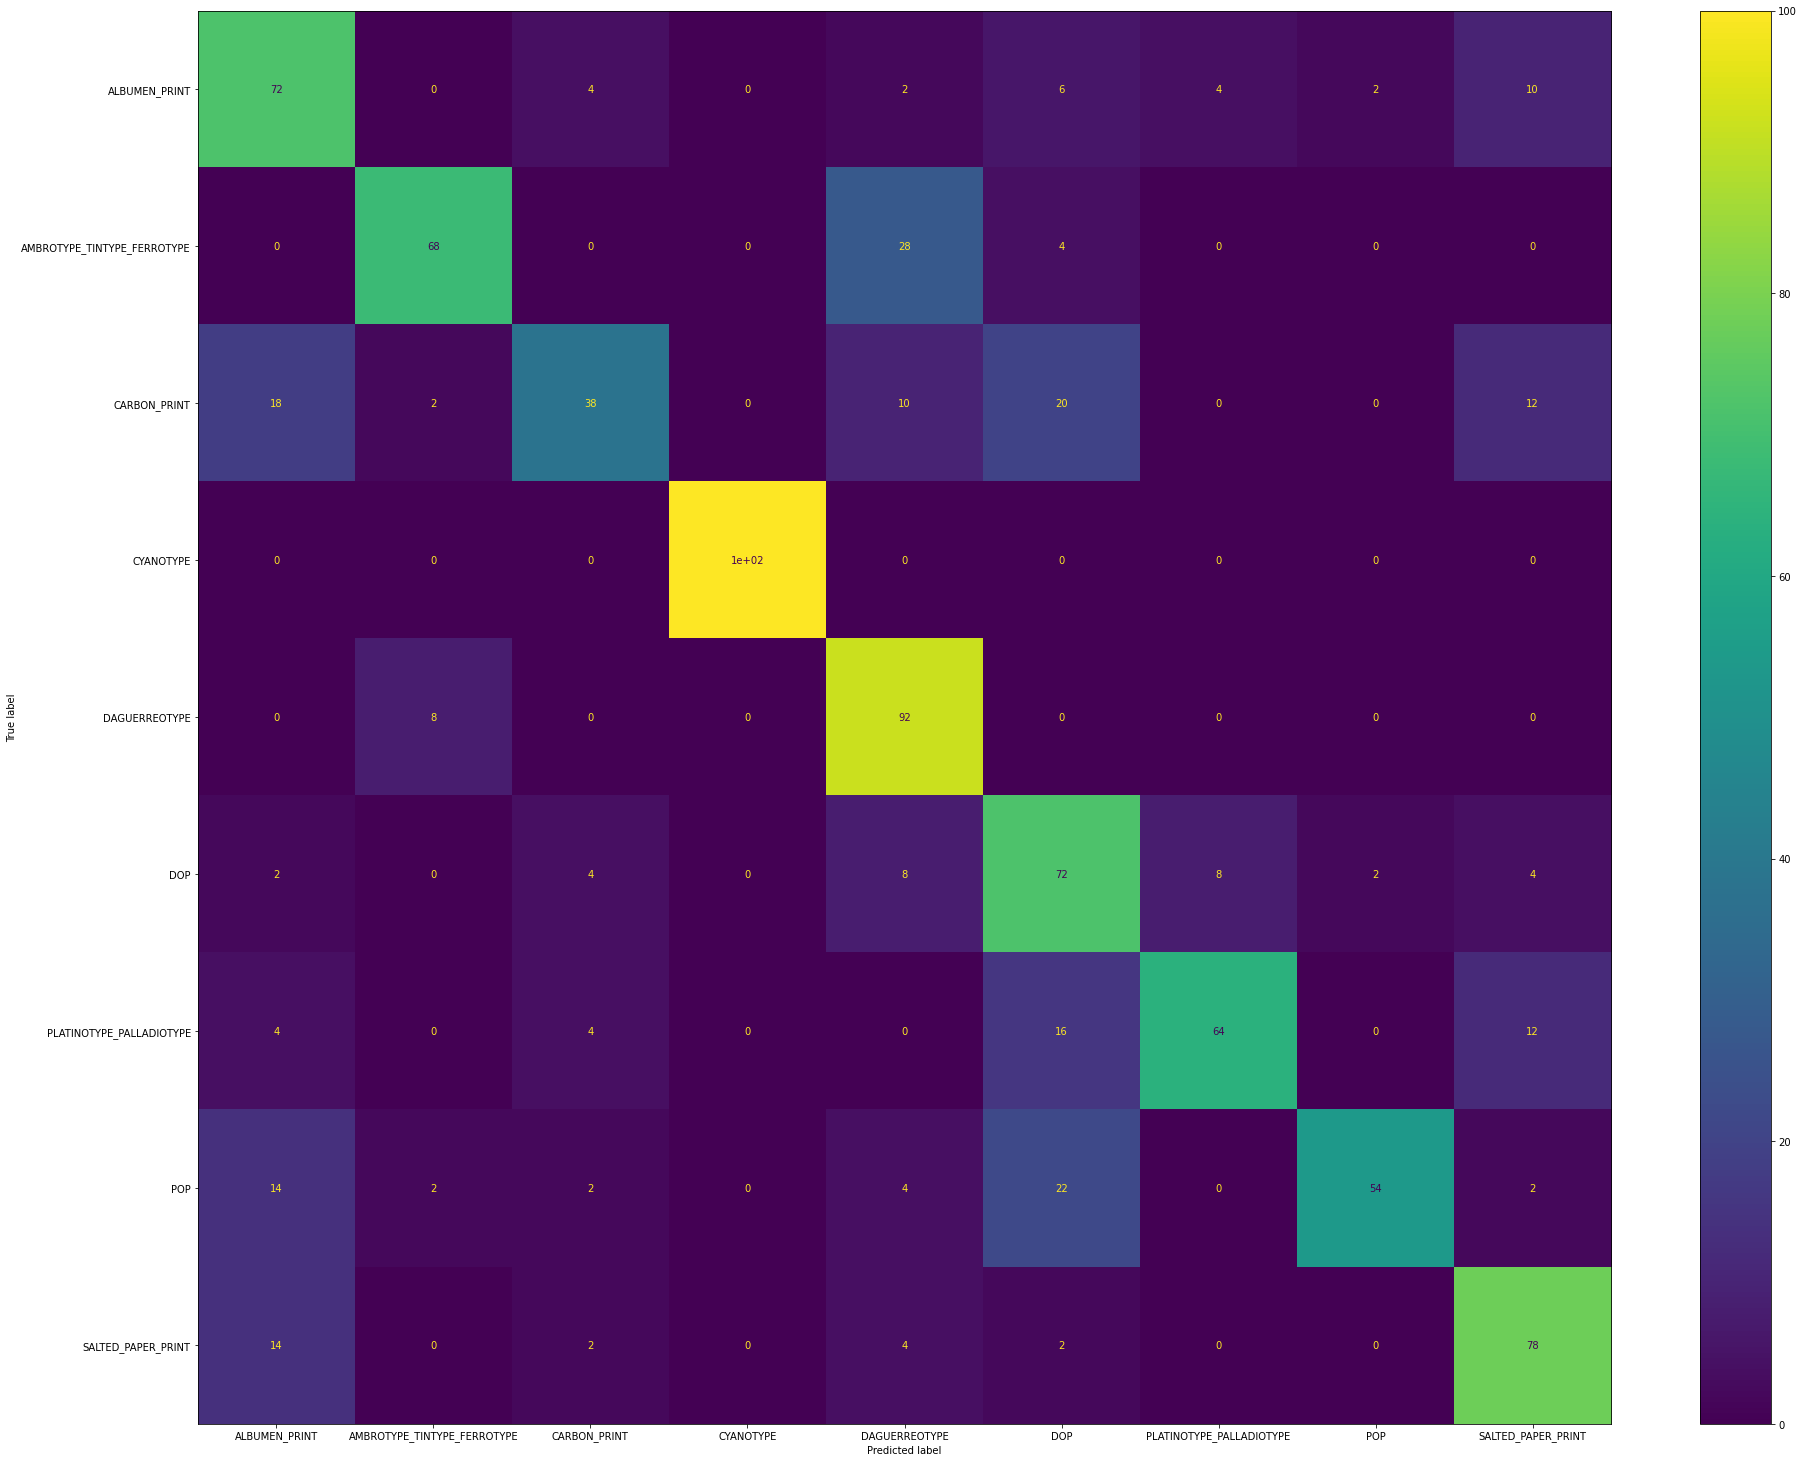

In [ ]:
# Confusion matrix
pred_y = model.predict(val_ds)
pred_y = np.argmax(pred_y, axis=1).tolist()
true_y = []
for id, data in val_ds.enumerate(start=0).as_numpy_iterator():
    true_y = true_y + data[1].tolist()

labels = os.listdir("drive/My Drive/CLASSIFY_BALANCED_VAL/TRAIN")
labels.sort()
cm = confusion_matrix(true_y, pred_y)
cm = np.apply_along_axis(lambda x: x / sum(x) * 100, 1, cm)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(32, 26))
cmp.plot(ax=ax)

In [ ]:
model.save("drive/My Drive/Models/MULTICLASS")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
